# Final assignment

### Practical Session

<br/> student:Raimundas Pocius
<br/> email: raimundas.po8348@go.kauko.lt

## Project download 10 years of stock market data from website: https://finance.yahoo.com/  and obtain its stock price


## Data loading and pre-processing

In [121]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Import the dataset

In [122]:
#importing the dataset
# load the file contents 
dataset_train = pd.read_csv('GOOG_train.csv')

In [123]:
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-07-30,220.478592,224.892044,220.478592,221.987930,221.987930,6421000
1,2009-07-31,224.149826,225.504745,220.388931,220.697769,220.697769,5742200
2,2009-08-03,223.532150,226.102509,222.984207,225.260666,225.260666,5199900
3,2009-08-04,223.845978,226.152328,223.377731,226.017822,226.017822,4797400
4,2009-08-05,227.148590,227.601898,223.103760,224.727661,224.727661,4701400


In [124]:
# Create a subtable of relevant entries (open values)
# The .values makes this vector a numpy array
training_set = dataset_train.iloc[:, 1:2].values 

In [125]:
# Seperating "Open" column data because we are going to use it to train our neural network
training_set = dataset_train.iloc[:, 1:2].values 
# Show separated "Open" colum data in an array
training_set

array([[ 220.478592],
       [ 224.149826],
       [ 223.53215 ],
       ...,
       [1224.040039],
       [1241.050049],
       [1225.410034]])

Numpy arrays do not support the view() and head() methods. [More on accessing the numpy data](https://jakevdp.github.io/PythonDataScienceHandbook/02.02-the-basics-of-numpy-arrays.html)


### Feature Scaling

Next we need to rescale our data to the range from 0 to 1. 

In [126]:
# Feature Scaling

# import the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [127]:
# create a scaler instance to rescale all data to the range of 0 to 1
sc = MinMaxScaler(feature_range = (0, 1))

In [128]:
# create the actual training set of scaled values
training_set_scaled = sc.fit_transform(training_set)

In [129]:
#Then we check it with:
training_set_scaled

array([[0.00202903],
       [0.00550668],
       [0.00492157],
       ...,
       [0.95267434],
       [0.96878745],
       [0.9539721 ]])

### Splitting the training set to dependent and independent variables

In [130]:
# Creating a data structure 

# the 90 stock prices in the almos last 5  months before today
X_train = [] 

In [131]:
# the stock price today
y_train = [] 

In [132]:
# we start from day 90 because that is the first instance allowing us to 
# go back 90 days
for i in range(90, 2517): 
    # 0 is the column ID, the only column in this case.    
    # put the last 90 days values in one row of X_train
    X_train.append(training_set_scaled[i-90:i, 0]) 
    y_train.append(training_set_scaled[i, 0])


In [210]:
#Converting the X and Y arrays into NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_train

array([[[0.00202903],
        [0.00550668],
        [0.00492157],
        ...,
        [0.07204938],
        [0.07112454],
        [0.07300258]],

       [[0.00550668],
        [0.00492157],
        [0.00521885],
        ...,
        [0.07112454],
        [0.07300258],
        [0.06884543]],

       [[0.00492157],
        [0.00521885],
        [0.00834733],
        ...,
        [0.07300258],
        [0.06884543],
        [0.06851038]],

       ...,

       [[0.91930198],
        [0.9273916 ],
        [0.94505824],
        ...,
        [0.87685468],
        [0.86539272],
        [0.87100049]],

       [[0.9273916 ],
        [0.94505824],
        [0.95483404],
        ...,
        [0.86539272],
        [0.87100049],
        [0.95267434]],

       [[0.94505824],
        [0.95483404],
        [0.92699382],
        ...,
        [0.87100049],
        [0.95267434],
        [0.96878745]]])

### Reshaping the Matrix

We need to add a new matrix dimension to accommodate the indicator (predictor). 

NumPy matrices are tensors (3D) and essentially we need to specify that our matrix consists of **60 days** (dimension x) times **total days in data set** (dimension y) times **1 value per matrix cell (scalar)** (dimension z)

In [135]:
# Reshaping the data matrix, we retain the 2 original dimensions and add a third of depth=1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the RNN

In [136]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [137]:
# Initialising the RNN as a sequence of layers
regressor = Sequential()

### Add First Layer

In [138]:
# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape =  (X_train.shape[1], 1)))

In [139]:
# the argument is the dropout rate to ignore in the layers (20%), 
regressor.add(Dropout(0.2))


### Add More Layers
We can add more LSTM layers but along with Dropout regularization to make sure we avoid overfitting! 

In [140]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [141]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [142]:
# Adding a fourth LSTM layer and some Dropout regularisation
# we removed the return_sequences because we no longer return a 
# sequence but a value instead
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### let's add Output Layer & Compiling

The output has 1 dimension , i.e. one value to be predicted thus or output fully connected layer has dimensionality = 1.

- **Optimizer**: rmsprop is recommended in the Keras documentation. The Adam optimizer is also a powerful choice.
- **Loss function**: regression problems take the mean square error as most common

In [143]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [144]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Train and deploy the RNN

### Fit the RNN to the Training set

We now want to train our RNN using the data in our **Training Set X** and **predictors in y** (ground truth in this case). Parameters that can be specified are the:

- **Batch size**:  update the cell weights not on every stock price on every batch_size values; 
- **Number of epochs**: how many iterations to be used, i.e. number of forward and backward propagations for the update of the weights


In [194]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
2427/2427 [==============================] - 18s 7ms/step - loss: 7.8190e-04
Epoch 2/100
2427/2427 [==============================] - 18s 7ms/step - loss: 8.2427e-04
Epoch 3/100
2427/2427 [==============================] - 18s 7ms/step - loss: 8.0402e-04
Epoch 4/100
2427/2427 [==============================] - 18s 7ms/step - loss: 8.2795e-04
Epoch 5/100
2427/2427 [==============================] - 18s 7ms/step - loss: 7.5294e-04
Epoch 6/100
2427/2427 [==============================] - 18s 7ms/step - loss: 8.6132e-04
Epoch 7/100
2427/2427 [==============================] - 18s 7ms/step - loss: 8.6540e-04
Epoch 8/100
2427/2427 [==============================] - 17s 7ms/step - loss: 9.3515e-04
Epoch 9/100
2427/2427 [==============================] - 18s 7ms/step - loss: 7.4507e-04
Epoch 10/100
2427/2427 [==============================] - 18s 7ms/step - loss: 7.5846e-04
Epoch 11/100
2427/2427 [==============================] - 18s 7ms/step - loss: 7.5284e-04
Epoch 12/100
2427/2

### Computing Predictions

Create a data-frame by importing the Google Stock Price Test set for January 2017 using pandas and make it a numpy array.

There are 20 financial days in one month, weekends are excluded!


In [195]:
# Getting the real stock price for February 1st 2012 - 
dataset_test = pd.read_csv('GOOG_test.csv')
dataset_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-07-30,1225.410034,1234.869995,1223.300049,1225.140015,1225.140015,1453300
1,2019-07-31,1223.000000,1234.000000,1207.764038,1216.680054,1216.680054,1725500
2,2019-08-01,1214.030029,1234.109985,1205.719971,1209.010010,1209.010010,1698500
3,2019-08-02,1200.739990,1206.900024,1188.939941,1193.989990,1193.989990,1645100
4,2019-08-05,1170.040039,1175.239990,1140.140015,1152.319946,1152.319946,2597500
5,2019-08-06,1163.310059,1179.959961,1160.000000,1169.949951,1169.949951,1709400
6,2019-08-07,1156.000000,1178.444946,1149.624023,1173.989990,1173.989990,1444300
7,2019-08-08,1182.829956,1205.010010,1173.020020,1204.800049,1204.800049,1468000
8,2019-08-09,1197.989990,1203.880005,1183.603027,1188.010010,1188.010010,1065700
9,2019-08-12,1179.209961,1184.959961,1167.671997,1174.709961,1174.709961,1003000


In [196]:
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price.size

24

In [197]:
real_stock_price

array([[1225.410034],
       [1223.      ],
       [1214.030029],
       [1200.73999 ],
       [1170.040039],
       [1163.310059],
       [1156.      ],
       [1182.829956],
       [1197.98999 ],
       [1179.209961],
       [1171.459961],
       [1176.310059],
       [1163.5     ],
       [1179.550049],
       [1190.089966],
       [1195.25    ],
       [1193.150024],
       [1194.069946],
       [1181.98999 ],
       [1157.26001 ],
       [1180.530029],
       [1161.709961],
       [1181.119995],
       [1198.5     ]])

In [198]:

# axis = 0 means concatenate the lines (i.e. vertical axis)
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) 

In [199]:
dataset_total.size


2541

In [200]:
# the difference in the length of the first two gives us 
# the first day in 2019, and we need to go back 90 days to get the necessary range
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 90:].values

In [201]:
inputs.size

114

In [202]:
# we did not use iloc from panda so lets reshape the numpy array for 
# compatibility: i.e. all the values from input lines to be stacked in one 
# column. The -1 means that the numpy has no knowledge of how the 
# values were stored in lines. The 1 means we want to them in one 
# column.

inputs = inputs.reshape(-1,1) 

# apply the feature scaler
inputs = sc.transform(inputs)

In [211]:
# Getting the predicted stock price of 2017
X_test = []

In [212]:
# the first 90 from inputs are from training set; start 
# from 90 and get the extra 20, i.e. up to 110
for i in range(90, 110): 
    X_test.append(inputs[i-90:i, 0])


In [213]:
X_test = np.array(X_test) # not 3D structure yet

In [214]:
# create a 3D structure
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [215]:
predicted_stock_price = regressor.predict(X_test)

In [216]:
# need to inverse the scaling to get meaningful predicted stock price # outputs
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 
predicted_stock_price.size

20

### Result Visualization


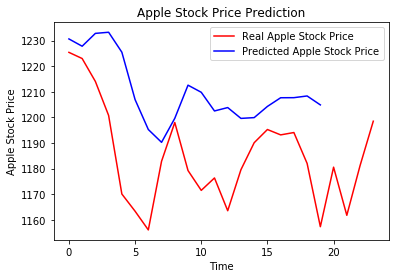

In [209]:
# Visualising the results

plt.plot(real_stock_price, color = 'red', label = 'Real Apple Stock Price')

plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Apple Stock Price')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()

plt.show()

The blue line shows the trend of the stock for the month of January 2017. 

Some observations:
- The prediction lags behind the actual price curve because the model cannot react to fast non-linear changes. Spikes are examples of fast non-linear changes
- Model reacts pretty well to smooth changes

### Compute the RMSE

If we need to compute the RMSE for our Stock Price Prediction problem, we use the real stock price and predicted stock price as shown.

Then consider dividing this RMSE by the range of the Google Stock Price values of January 2017 to get a relative error, as opposed to an absolute error. 


In [103]:
#import the libraries
import math
from sklearn.metrics import mean_squared_error

In [104]:
rmse = math.sqrt( mean_squared_error( real_stock_price[0:20,:], predicted_stock_price))
rmse

92.9800080889726